In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import math
from scipy.stats import iqr
from numpy import linalg
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import pickle

In [2]:
## Features

def mean(x):
    """Calculates mean"""
    mean_x = np.mean(x)
    return mean_x

def std_dev(x):
    """Calculates standard deviation"""
    std_x = np.std(x)
    return std_x
    
def mad(x):
    """Calculates median absolute deviation"""
    mad_x = np.median(np.abs(x - np.median(x)))
    return mad_x

def minimum(x):
    """Calculates minimum"""
    return min(x)

def maximum(x):
    """Calculates maximum"""
    return max(x)

def energy_measure(x):
    """Calculates energy measures"""
    em_x = np.mean(np.square(x))
    return em_x

def inter_quartile_range(x):
    """Calculates inter-quartile range"""
    iqr_x = np.subtract(*np.percentile(x, [75, 25]))
    return iqr_x

def sma(x,y,z):
    """Calculates signal magnitude area"""   
    abs_x = np.absolute(x)
    abs_y = np.absolute(y)
    abs_z = np.absolute(z)
    return np.mean(abs_x+abs_y+abs_z)

def skewness(x):
    """Calculates skewness"""
    skew_x=stats.skew(x)
    return skew_x

def kurt(x):
    """Calculates kurtosis"""
    kurt_x = stats.kurtosis(x,fisher=False)
    return kurt_x
    
def max_index(x):
    """Calculates index of maximum"""
    idx_x = np.argmax(x)
    return idx_x

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [3]:
macc_cols = ['mad_macc', 'min_macc', 'max_macc', 'em_macc', 'sma_macc', 'label']

def process_mag_acc(input_df, columns, output_df):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()
    
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[6][i]]
        l = input_df[5][i]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        
        
        mad_macc = mad(x)
        min_macc = minimum(x)
        max_macc = maximum(x)
        em_macc = energy_measure(x)
        sma_macc = np.mean(np.absolute(x))  
        
        macc_data = [mad_macc,min_macc, max_macc, em_macc, sma_macc, l]
        output_df = output_df.append(pd.Series(macc_data, index=columns), ignore_index=True)

    return output_df

In [4]:
maccj_cols = ['mad_macc_jerk', 'min_macc_jerk', 'iqr_macc_jerk', 'sma_macc_jerk']
def process_mag_acc_jerk(input_df, columns, output_df):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()
    
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[6][i]]
        l = input_df[5][i]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        mad_macc_jerk = mad(x)
        min_macc_jerk = minimum(x)
        iqr_macc_jerk = inter_quartile_range(x)
        sma_macc_jerk = np.mean(np.absolute(x))
        
        maccj_data = [mad_macc_jerk, min_macc_jerk, iqr_macc_jerk, sma_macc_jerk]
        output_df = output_df.append(pd.Series(maccj_data, index=columns), ignore_index=True)

    return output_df

In [5]:
facc_jmag_cols = ['std_mfacc_jerk', 'mad_mfacc_jerk', 'iqr_mfacc_jerk']

def process_faccj_mag(input_df, columns, output_df):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()
    i = 0

    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[6][i]]

        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break
                
        label = (input_df[5][1], )
        if label == 'null':
            print('--------null')
            return
        
        std_acc = std_dev(x)
        iqr_acc = inter_quartile_range(x)
        mad_acc = mad(x)

        acc_data = [std_acc, mad_acc, iqr_acc]
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [6]:
def hist_activities(df):
    df['label'].value_counts().plot(kind='bar', title='Training examples by activity type')
    plt.show()
    
def plot_activity(activity, df):
    data = df[df.iloc[:, 5] == activity][[1, 2, 3]][:2000]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
def plot_act_signals(df):
    plot_activity("sitting", df)
    plt.ylabel('sitting')
    plt.show()
    plot_activity("walking", df)
    plt.ylabel('walking')
    plt.show()
    plot_activity("standing", df)
    plt.ylabel('standing')
    plt.show()
    plot_activity("laying_down", df)
    plt.ylabel('laying_down')
    plt.show()

In [7]:
def calc_jerk(acc, ts):
    jk = [0]* len(acc)
    for i in range(1,len(acc)):
        jk[i-1] = 1000*(acc[i] - acc[i-1])/(ts[i] - ts[i-1])
    return jk

def fmagnitude(num):
    return math.sqrt(num.real**2 + num.imag**2)

In [8]:
def get_session_dirs(path):
    path = path
    dirs = []
    dir_list = [x[0] for x in os.walk(path)]
    last_dirs = ["1_android.sensor.accelerometer.data.csv.gz","4_android.sensor.gyroscope.data.csv.gz"]
    dirs = []
    for each_dir in dir_list[2:]:

        if "data" in each_dir:
            dirs.append(each_dir)

    dirs.sort(key=lambda x:x[-22:])
    return dirs

In [9]:
def get_jerk(df):
    df[1] = calc_jerk(df[1],df[0])
    df[2] = calc_jerk(df[2],df[0])
    df[3] = calc_jerk(df[3],df[0])
    return df

def get_fft(df):
    df[1] = np.fft.fft(df[1])
    df[2] = np.fft.fft(df[2])
    df[3] = np.fft.fft(df[3])
    df[1] = [fmagnitude(j) for j in df[1]]
    df[2] = [fmagnitude(j) for j in df[2]]
    df[3] = [fmagnitude(j) for j in df[3]]
    return df

def five_point_smoothing(df):
    m=np.array(df[1])
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
    df[1] = m_smooth
        
    m=np.array(df[2])
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
    df[2] = m_smooth
    
    m = np.array(df[3])
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
    df[3] = m_smooth
    
    return df

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

In [10]:
def process_csv_data(path):
    dirs = get_session_dirs(path)
    acc_mag = pd.DataFrame(columns = macc_cols)
    acc_jerk_mag = pd.DataFrame(columns = maccj_cols)
    facc_jerk_mag = pd.DataFrame(columns = facc_jmag_cols)
    
    acc_gy_df = pd.DataFrame()

    for i in dirs: 
        full_path_acc = os.path.normpath(i + "/" + "1_android.sensor.accelerometer.data.csv.gz")
        
        print("processing acceleration: " + full_path_acc)
        in_df_ac = pd.read_csv(full_path_acc, compression='gzip', sep=',', header=None)

        #cropping
        if in_df_ac.shape[0] > 3000:
    
            in_df_ac = in_df_ac.drop(list(range(1000)), axis = 0)
            in_df_ac.index = range(in_df_ac.shape[0])
            in_df_ac = in_df_ac.drop(list(range(in_df_ac.shape[0]-1000, in_df_ac.shape[0])), axis = 0)
            in_df_ac.index = range(in_df_ac.shape[0])
            
        #smoothing
        in_df_ac = five_point_smoothing(in_df_ac)
    
        #jerk
        in_df_ac_jerk = in_df_ac.copy()
        in_df_ac_jerk = get_jerk(in_df_ac_jerk)
        
        #fft
        in_df_fac = in_df_ac.copy()
        in_df_fac = get_fft(in_df_fac)
        
        #fft_jerk
        in_df_fac_jerk = in_df_ac_jerk.copy()
        in_df_fac_jerk = get_fft(in_df_fac_jerk)

        acc_mag = process_mag_acc(in_df_ac, macc_cols, acc_mag)
        acc_jerk_mag = process_mag_acc_jerk(in_df_ac_jerk, maccj_cols, acc_jerk_mag)
        facc_jerk_mag = process_faccj_mag(in_df_fac_jerk, facc_jmag_cols, facc_jerk_mag)
        acc_gy_df = pd.concat([acc_jerk_mag, facc_jerk_mag, acc_mag], axis=1)

    print(acc_gy_df.shape)
    return acc_gy_df

In [11]:
training_set_df = process_csv_data("Sessions/")

processing acceleration: Sessions3-full\14442D57F7E1B88_Tue_Mar_06_18-33_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Sessions3-full\14442D57F7E1B88_Wed_Mar_07_11-53_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Sessions3-full\14442D57F7E1B88_Wed_Mar_07_13-36_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Sessions3-full\14442D57F7E1B88_Wed_Mar_07_13-42_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Sessions3-full\14442D57F7E1B88_Wed_Mar_07_13-44_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Sessions3-full\14442D57F7E1B88_Wed_Mar_07_13-57_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Sessions3-full\14442D57F7E1B88_Thu_Feb_08_00-16_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Sessions3-full\14442D57F7E1B88_Thu_Feb_08_00-18_2018_PST\data\1_a

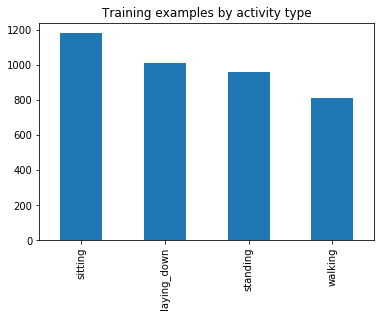

,mad_macc_jerk,min_macc_jerk,iqr_macc_jerk,sma_macc_jerk,std_mfacc_jerk,mad_mfacc_jerk,iqr_mfacc_jerk,mad_macc,min_macc,max_macc,em_macc,sma_macc,label
853,0.810269,0.178663,1.676020,2.519056,663.979647,478.818374,956.446390,0.017800,9.126425,9.317504,85.550563,9.249317,laying_down
2470,0.667521,0.170738,1.349984,2.388494,25947.808736,18686.411029,37605.332780,0.009800,9.624984,9.717329,93.458765,9.667395,laying_down
506,16.847106,1.897452,37.165755,46.559281,4569.266788,3076.435502,6166.646767,1.404407,6.839887,18.038666,121.995489,10.832138,walking
2255,24.443641,0.313032,59.128621,51.657892,5081.327830,3347.761312,6752.391173,0.275047,1.642862,15.477629,96.556101,9.758634,sitting
2829,3.256233,0.353142,6.977196,8.184784,1301.559871,864.966609,1777.955788,0.054472,9.627217,10.603044,101.129052,10.055586,sitting


In [12]:
hist_activities(training_set_df)
#plot_act_signals(in_df_ac)
training_set_df.to_csv("train_feat12.csv")
#training_set_df = pd.read_csv("train_feat12.csv", sep=',', header=None)

training_set_df = clean_dataset(training_set_df)

combined_training_df = training_set_df
combined_training_df = combined_training_df.iloc[np.random.permutation(len(combined_training_df))]
combined_training_df.head()

In [13]:
fileobj = open("combineddf",'wb') 
pickle.dump(combined_training_df, fileobj)
fileobj.close()


In [ ]:
f = open("combineddf", 'r')
combined_training_df = pickle.load(f)
f.close()

In [14]:
## Training set

training_data = combined_training_df[facc_jmag_cols+ maccj_cols+ macc_cols].as_matrix()
training_targets = training_data[:, -1]
training_data = training_data[:, :-1]

std_scale = preprocessing.StandardScaler().fit(training_data)
training_data_std = std_scale.transform(training_data)

print(len(training_data_std), len(training_data_std[0]))
print(len(training_targets))

cache = {'laying_down' : 0, 'sitting' : 1, 'walking' : 2, 'standing' : 3}
training_targets.reshape(len(training_targets))
print(training_targets)
print(training_targets.shape)

training_bin_targets = []
for i in training_targets:
    training_bin_targets.append(cache[i])
print(len(training_bin_targets))

training_bin_targets[: 5]

(3959, 12)
3959
['laying_down' 'laying_down' 'walking' ..., 'standing' 'standing'
 'laying_down']
(3959L,)
3959


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[0, 0, 2, 1, 1]

In [15]:
## Testing set
testing_set_df = process_csv_data('Test/')

processing acceleration: Test1\14442D53F81BFEA_Mon_Mar_05_21-54_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Test1\14442D53F81BFEA_Mon_Mar_05_22-01_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Test1\14442D53F81BFEA_Mon_Mar_05_22-06_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing acceleration: Test1\14442D53F81BFEA_Mon_Mar_05_22-14_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
(246, 13)


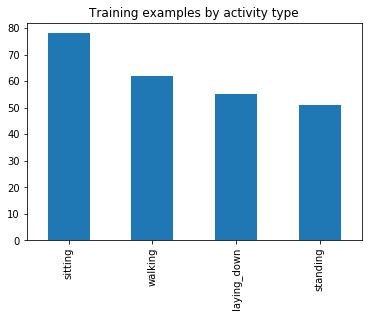

   mad_macc_jerk  min_macc_jerk  iqr_macc_jerk  sma_macc_jerk  std_mfacc_jerk  \
0       6.486658       0.497670      36.551227      37.555970    10359.834832   
1      30.078538       0.482442      75.531202      70.526370    10354.024571   
2      23.799503       0.482442      56.511297      64.561295    12195.405454   
3      14.612629       0.613749      36.838603      33.306843    12219.383768   
4       5.031943       0.524822      13.060006      18.466302    12315.352013   

   mad_mfacc_jerk  iqr_mfacc_jerk  mad_macc  min_macc   max_macc     em_macc  \
0     7164.478061    14437.441429  0.150934  4.664813  17.564620  101.415949   
1     6984.974209    14018.530783  0.526478  4.564220  19.553360  104.117344   
2     8281.999556    16924.103055  0.367884  4.564220  19.553360  101.049449   
3     8299.069413    16534.115459  0.159578  5.899200  12.998641   99.232530   
4     8786.140902    17348.383306  0.062758  6.920704  16.499057   99.736771   

    sma_macc    label  
0   9.98

In [16]:
hist_activities(testing_set_df)
# plot_act_signals(in_df_ac)
testing_set_df.to_csv("test_feat12.csv")
#testing_set_df = pd.read_csv("test_feat12.csv", sep=',', header=None)

testing_set_df = clean_dataset(testing_set_df)

combined_testing_df = testing_set_df
combined_testing_df = combined_testing_df.iloc[np.random.permutation(len(combined_testing_df))]
print testing_set_df.head()

In [17]:
testing_data = combined_testing_df[facc_jmag_cols+ maccj_cols+ macc_cols].as_matrix()
testing_targets = testing_data[:, -1]
testing_data = testing_data[:, :-1]

std_scale = preprocessing.StandardScaler().fit(testing_data)
testing_data_std = std_scale.transform(testing_data)

print(len(testing_data_std), len(testing_data_std[0]))
print(len(testing_targets))

cache = {'laying_down' : 0, 'sitting' : 1, 'walking' : 2, 'standing' : 3}
testing_targets.reshape(len(testing_targets))
print(testing_targets.shape)

testing_bin_targets = []
for i in testing_targets:
    testing_bin_targets.append(cache[i])
print(len(testing_bin_targets))

testing_bin_targets[: 5]

(246, 12)
246
(246L,)
246


[3, 2, 0, 1, 1]

In [18]:
fileobj = open("combinedtestdf",'wb') 
pickle.dump(combined_testing_df, fileobj)
fileobj.close()


In [ ]:
f = open("combinedtestdf", 'r')
combined_testing_df = pickle.load(f)
f.close()

In [50]:
#model = DecisionTreeClassifier(random_state=0)
model = RandomForestClassifier(random_state = 42)
#model = SVC()
#model = KNeighborsClassifier()
#model = GaussianNB()
#model = LogisticRegression()
#model = MLPClassifier()

# Training the model
model.fit(training_data, training_bin_targets)

# Testing on the testing data
predicted_values = model.predict(testing_data)

In [51]:
cvscore = cross_val_score(model, testing_data, testing_bin_targets, cv=10)
print(cvscore)
print(np.mean(cvscore))

[ 0.77777778  0.84615385  0.92        0.96        0.6         0.91666667
  0.875       0.70833333  0.82608696  0.86956522]
0.829958379784


In [52]:
acc_score = accuracy_score(testing_bin_targets, predicted_values)
print("Score: ", acc_score)

('Score: ', 0.58130081300813008)
